In [1]:
import pandas as pd

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt

2024-02-06 15:17:00.548077: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-06 15:17:01.108724: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Setup and Configuration

In [2]:
# North Carolina data
url = "https://github.com/geo-smart/flood-risk-ml-tutorial/blob/main/North_Carolina_Buildings.zip?raw=true"

# read data into a Pandas dataframe
rawDf = pd.read_csv(url, compression="zip")

# ignore first few columns, which are FIPs codes, not needed for ML
rawDf = rawDf.iloc[:, 3:] 
df = rawDf.copy( deep=True )

In [3]:
# classify a building as "Residential", "Commercial", or "Other"
df.loc[df["BuildingType"] == "Industrial", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Assembly", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Education", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Government", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Agriculture", "BuildingType"] = 'Other'
df.loc[df["BuildingType"] == "Utility and Misc", "BuildingType"] = 'Other'

# building type distributions
print()
print( df['BuildingType'].value_counts() )
print()
print( 976690/df['BuildingType'].value_counts() )
print()


Residential    976690
Commercial      64029
Other           37425
Name: BuildingType, dtype: int64

Residential     1.000000
Commercial     15.253869
Other          26.097261
Name: BuildingType, dtype: float64



In [4]:
from sklearn import preprocessing

df = df.sample(frac=1) # shuffle the dataframe (technically, we randomly resample the entire df)

# preprocess the data - scaling
scaler = preprocessing.StandardScaler()
    
columns = ['X', 'Y', 'Area', 'MedianIncomeCounty', 
           'HousingUnitsCounty', 'HousingDensityCounty',
           'Impervious', 'AgCount', 'CmCount', 'GvCount',
           'EdCount', 'InCount']
df[columns] = scaler.fit_transform(df[columns])

df = df.dropna()

nCols = df.shape[1]
le = preprocessing.LabelEncoder()
le.fit( df.iloc[:, nCols-1] ) # ornl type
df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
    
le2 = preprocessing.LabelEncoder()
le2.fit( df.iloc[:, nCols-2] ) # nearest road type
df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )

/tmp/ipykernel_33330/1358776107.py:19: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, nCols-1] = le.transform( df.iloc[:, nCols-1] )
/tmp/ipykernel_33330/1358776107.py:23: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.iloc[:, nCols-2] = le2.transform( df.iloc[:, nCols-2] )


In [5]:
df.head()

,X,Y,Area,MedianIncomeCounty,HousingUnitsCounty,HousingDensityCounty,Impervious,AgCount,CmCount,GvCount,EdCount,InCount,OsmNearestRoad,BuildingType
12790,-0.804473,-0.375300,-0.081564,-0.099105,-1.052135,-0.760445,0.404579,-0.807762,-1.045352,-1.048588,-1.064738,-0.999500,4,2
788359,0.674385,0.559765,-0.116762,1.302284,0.963812,-0.339621,-0.400575,1.665731,0.880503,0.643556,1.097817,1.041934,4,2
89106,-0.867942,-1.359846,-0.058006,0.139001,-1.071597,-1.424272,-1.205730,-0.189389,-1.054971,-1.048588,-1.045623,-0.770605,4,2
101348,-0.853374,-0.832728,-0.119094,0.139001,-1.071597,-1.424272,1.030811,-0.189389,-1.054971,-1.048588,-1.045623,-0.770605,4,2
684258,-0.954170,-0.494661,-0.065904,0.337253,1.051850,0.031186,-0.654050,-0.337799,1.140185,1.278110,0.949244,0.979654,4,2


In [6]:
nClasses = len(df['BuildingType'].unique())
print("Number of classes:", nClasses)

Number of classes: 3


In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df[['BuildingType']])

nCols = test.shape[1]
xTest = test.iloc[:, :nCols-1]
yTest = test.iloc[:, nCols-1]

xTrain = train.iloc[:, :nCols-1]
yTrain = train.iloc[:, nCols-1]

print("Training Size:", xTrain.shape)
print("Testing Size:", xTest.shape)

# save test/train split
xTrain.to_pickle("./xTrain.pkl") 
yTrain.to_pickle("./yTrain.pkl") 
xTest.to_pickle("./xTest.pkl")  
yTest.to_pickle("./yTest.pkl")  

Training Size: (862513, 13)
Testing Size: (215629, 13)


### Bayesian Neural Network

In [7]:
xTrain = pd.read_pickle("./xTrain.pkl")  
yTrain = pd.read_pickle("./yTrain.pkl")  
xTest = pd.read_pickle("./xTest.pkl")  
yTest = pd.read_pickle("./yTest.pkl")  

In [9]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
total = xTrain.shape[0]
ix = np.where( yTrain == 0 )
zero = len(ix[0])
ix = np.where( yTrain == 1 )
one = len(ix[0])
ix = np.where( yTrain == 2 )
two = len(ix[0])

weight_for_0 = (1 / zero) * (total / 2.0)
weight_for_1 = (1 / one) * (total / 2.0)
weight_for_2 = (1 / two) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))

Weight for class 0: 8.42
Weight for class 1: 14.40
Weight for class 2: 0.55


In [8]:
from keras import backend as K 

# Keras keeps models hanging around in memory. If we retrain a model, Keras will
# start from the previously concluded weight values. This resets everything.
K.clear_session()

# KL divergence weighted by the number of training samples, using
# lambda function to pass as input to the kernel_divergence_fn on
# flipout layers.
kl_divergence_function = (lambda q, p, _: tfd.kl_divergence(q, p) /  
                            tf.cast(xTrain.shape[0], dtype=tf.float32))

tfd = tfp.distributions

# Define a logistic regression model as a Bernoulli distribution
# parameterized by logits from a single linear layer. We use the Flipout
# Monte Carlo estimator for the layer: this enables lower variance
# stochastic gradients than naive reparameterization.
input_layer = tf.keras.layers.Input(shape=xTrain.shape[1])

#dense_layer = tfp.layers.DenseFlipout(
#    units=1,
#    activation='sigmoid',
#    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
#    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
#    kernel_divergence_fn=kl_divergence_function)(input_layer)

layer1 = tfp.layers.DenseFlipout(
    units=26,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(input_layer)

layer2 = tfp.layers.DenseFlipout(
    units=13,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer1)

layer3 = tfp.layers.DenseFlipout(
    units=8,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer2)

layer4 = tfp.layers.DenseFlipout(
    units=4,
    activation='sigmoid',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer3)

out = tfp.layers.DenseFlipout(
    units=3,
    activation='softmax',
    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    bias_posterior_fn=tfp.layers.default_mean_field_normal_fn(),
    kernel_divergence_fn=kl_divergence_function)(layer4)

# Model compilation
#bnn = tf.keras.Model(inputs=input_layer, outputs=dense_layer)
bnn = tf.keras.Model(inputs=input_layer, outputs=out)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
  
# We use the binary_crossentropy loss since this toy example contains
# two labels. The Keras API will then automatically add the
# Kullback-Leibler divergence (contained on the individual layers of
# the model), to the cross entropy loss, effectively
# calcuating the (negated) Evidence Lower Bound Loss (ELBO)
bnn.compile(optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

/home/jupyter-narock/.local/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:98: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
2024-02-06 15:17:34.980882: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5337 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN Black, pci bus id: 0000:65:00.0, compute capability: 3.5
/home/jupyter-narock/.local/lib/python3.9/site-packages/tensorflow_probability/python/layers/util.py:108: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(


In [9]:
bnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_flipout (DenseFlipout  (None, 26)               728       
 )                                                               
                                                                 
 dense_flipout_1 (DenseFlipo  (None, 13)               702       
 ut)                                                             
                                                                 
 dense_flipout_2 (DenseFlipo  (None, 8)                224       
 ut)                                                             
                                                                 
 dense_flipout_3 (DenseFlipo  (None, 4)                72        
 ut)                                                         

In [12]:
history = bnn.fit( xTrain, tf.one_hot(yTrain,nClasses), 
                   epochs=25, verbose=1, batch_size=128, class_weight=class_weight,
                   use_multiprocessing=True, validation_split=0.2)

Epoch 1/25


2023-11-26 13:58:36.154323: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7f7e6797aa50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-26 13:58:36.154356: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA GeForce GTX TITAN Black, Compute Capability 3.5
2023-11-26 13:58:36.159337: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-26 13:58:36.327544: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-11-26 13:58:36.385677: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-26 13:58:36.452123: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


5391/5391 [==============================] - 88s 15ms/step - loss: 1.1961 - accuracy: 0.8490 - val_loss: 0.4975 - val_accuracy: 0.8726
Epoch 2/25
5391/5391 [==============================] - 81s 15ms/step - loss: 1.1239 - accuracy: 0.8645 - val_loss: 0.4582 - val_accuracy: 0.8769
Epoch 3/25
5391/5391 [==============================] - 83s 15ms/step - loss: 1.0964 - accuracy: 0.8600 - val_loss: 0.4051 - val_accuracy: 0.8877
Epoch 4/25
5391/5391 [==============================] - 83s 15ms/step - loss: 1.0867 - accuracy: 0.8582 - val_loss: 0.4280 - val_accuracy: 0.8923
Epoch 5/25
5391/5391 [==============================] - 83s 15ms/step - loss: 1.0799 - accuracy: 0.8595 - val_loss: 0.4699 - val_accuracy: 0.8752
Epoch 6/25
5391/5391 [==============================] - 83s 15ms/step - loss: 1.0756 - accuracy: 0.8612 - val_loss: 0.5146 - val_accuracy: 0.8549
Epoch 7/25
5391/5391 [==============================] - 83s 15ms/step - loss: 1.0733 - accuracy: 0.8617 - val_loss: 0.4419 - val_accura

Text(0.5, 0, 'Epoch')

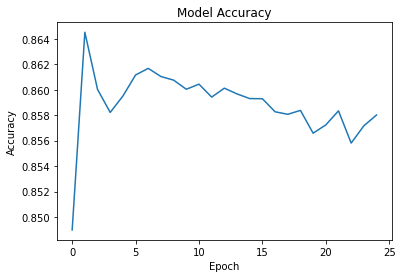

In [13]:
plt.plot( history.history['accuracy'], label="Accuracy")
#plt.plot( history.history['val_accuracy'], label="val_acc")
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
#plt.legend()

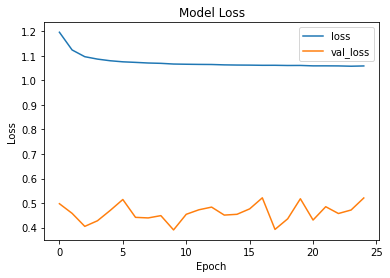

In [14]:
plt.plot( history.history['loss'], label="loss")
plt.plot( history.history['val_loss'], label="val_loss")
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

In [15]:
# serialize weights to HDF5
bnn.save_weights("bnn.h5")

### Analysis

In [10]:
nClasses = 3
bnn.load_weights("bnn.h5")

In [11]:
import numpy as np

def getPredictions( model, data, T ):

    n = data.shape[0]
    preds = np.zeros( shape=(n,nClasses,T) )
    
    for t in range(T):
        if ( t == 10 ): print("Iteration 10...")
        if ( t == 30 ): print("Iteration 30...")
        if ( t == 50 ): print("Iteration 50...")
        if ( t == 70 ): print("Iteration 70...")
        if ( t == 90 ): print("Iteration 90...")
        preds[:,:,t] = model(data)
        
    return preds

In [12]:
T = 100
preds = getPredictions( bnn, xTest.values, T )
preds.shape

Iteration 10...
Iteration 30...
Iteration 50...
Iteration 70...
Iteration 90...


(215629, 3, 100)

In [13]:
def getPredictions( preds, T ):
    
    n = preds.shape[0]
    means = np.zeros( shape=(n, nClasses) )
    
    for ix in range(n):
        for j in range(nClasses):
        
            means[ix,j] = np.mean( preds[ix,j,:] )
        
    bnnPreds = np.argmax( means, axis=1 )
    
    return means, bnnPreds

In [14]:
means, bnnPreds = getPredictions( preds, T )

In [15]:
means.shape, bnnPreds.shape

((215629, 3), (215629,))

In [16]:
from scipy.stats import entropy

base = 2  # work in units of bits
en = entropy(means, base=base, axis=1)

en.shape, yTest.shape

((215629,), (215629,))

Text(0.5, 1.0, 'Entropy of Incorrect Predictions')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


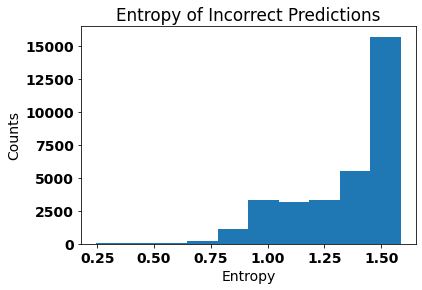

In [20]:
font = {'weight' : 'bold', 'size'   : 14}
plt.rc('font', **font)

correct = np.where( bnnPreds == yTest )
incorrect = np.where( bnnPreds != yTest )

plt.hist( en[incorrect] )
plt.xlabel( 'Entropy' )
plt.ylabel( 'Counts' )
plt.title( 'Entropy of Incorrect Predictions' )

In [21]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 22}
plt.rc('font', **font)

In [22]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix( yTest, bnnPreds, normalize='true' )

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


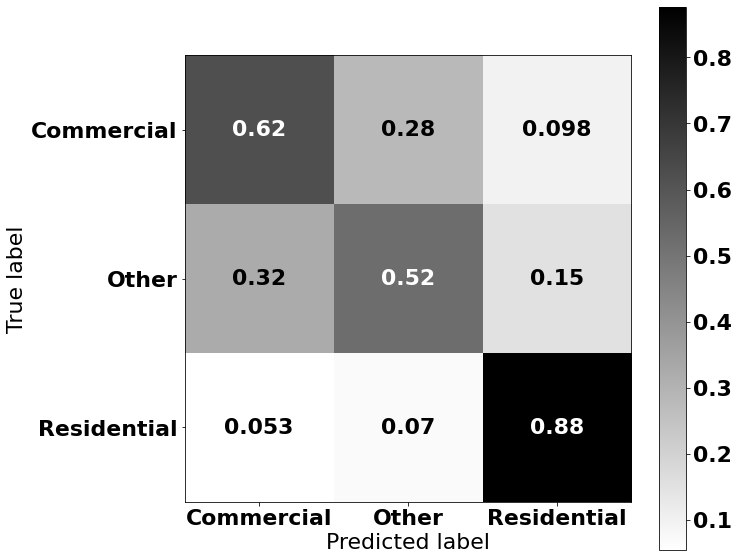

In [23]:
fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

In [24]:
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import balanced_accuracy_score

print( "Balanced Accuracy:", np.round( balanced_accuracy_score(yTest.values, bnnPreds), 4 ))
print( "Macro F1:", np.round( f1_score(yTest.values, bnnPreds, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(yTest.values, bnnPreds, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(yTest.values, bnnPreds, average='macro'), 4 ))

Balanced Accuracy: 0.6741
Macro F1: 0.5585
Macro Precision: 0.518
Macro Recall: 0.6741


#### Entropy-Accuracy Evaluation

In [25]:
testValues = np.arange(0.3, 1.6, 0.1)

acc = []
thr = []
pct = []

n = bnnPreds.shape[0]

for t in testValues:
    
    ixs = np.where( en <= t )
    y = yTest.values[ixs]
    x = bnnPreds[ixs]
    
    acc.append( balanced_accuracy_score(y,x) )
    thr.append( t )
    pct.append( len(ixs[0])/n )

    print( "Threshold:", t )
    print( "Percent of predictions:", len(ixs[0])/n )
    print( "Balanced Accuracy:", np.round( balanced_accuracy_score(y,x), 4 ))
    print( "Macro F1:", np.round( f1_score(y,x, average='macro'), 4 ))
    print( "Macro Precision:", np.round( precision_score(y,x, average='macro'), 4 ))
    print( "Macro Recall:", np.round( recall_score(y,x, average='macro'), 4 ))
    print()

Threshold: 0.3
Percent of predictions: 0.07928432631974364
Balanced Accuracy: 0.3333
Macro F1: 0.3331
Macro Precision: 0.3328
Macro Recall: 0.3333

Threshold: 0.4
Percent of predictions: 0.1410941941946584
Balanced Accuracy: 0.3333
Macro F1: 0.333
Macro Precision: 0.3327
Macro Recall: 0.3333

Threshold: 0.5
Percent of predictions: 0.18120011686739723
Balanced Accuracy: 0.3333
Macro F1: 0.3329
Macro Precision: 0.3325
Macro Recall: 0.3333

Threshold: 0.6000000000000001
Percent of predictions: 0.22383816648038993
Balanced Accuracy: 0.3333
Macro F1: 0.3329
Macro Precision: 0.3325
Macro Recall: 0.3333

Threshold: 0.7000000000000002
Percent of predictions: 0.2708030923484318
Balanced Accuracy: 0.3333
Macro F1: 0.3329
Macro Precision: 0.3324
Macro Recall: 0.3333

Threshold: 0.8000000000000003
Percent of predictions: 0.3685867856364404
Balanced Accuracy: 0.6264
Macro F1: 0.616
Macro Precision: 0.6062
Macro Recall: 0.6264

Threshold: 0.9000000000000001
Percent of predictions: 0.4479221255025993

/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedM

Macro Precision: 0.7764
Macro Recall: 0.761

Threshold: 1.0000000000000002
Percent of predictions: 0.5203381734367826
Balanced Accuracy: 0.7908
Macro F1: 0.7667
Macro Precision: 0.7472
Macro Recall: 0.7908

Threshold: 1.1000000000000003
Percent of predictions: 0.5946556353737206
Balanced Accuracy: 0.7561
Macro F1: 0.7233
Macro Precision: 0.698
Macro Recall: 0.7561

Threshold: 1.2000000000000004
Percent of predictions: 0.6571240417569065
Balanced Accuracy: 0.7473
Macro F1: 0.706
Macro Precision: 0.6767
Macro Recall: 0.7473

Threshold: 1.3000000000000005
Percent of predictions: 0.7256305969976209
Balanced Accuracy: 0.7364
Macro F1: 0.6851
Macro Precision: 0.6515
Macro Recall: 0.7364

Threshold: 1.4000000000000004
Percent of predictions: 0.8004025432571685
Balanced Accuracy: 0.7216
Macro F1: 0.658
Macro Precision: 0.6206
Macro Recall: 0.7216

Threshold: 1.5000000000000004
Percent of predictions: 0.8916982409601677
Balanced Accuracy: 0.7043
Macro F1: 0.6168
Macro Precision: 0.5768
Macro Re

(0.0, 1.0)

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


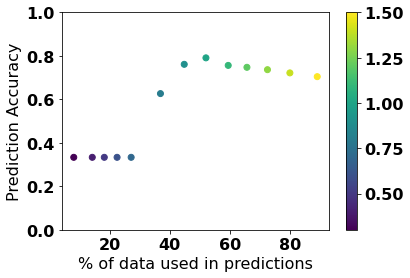

In [27]:
font = {'family' : 'normal',
    'weight' : 'bold',
    'size'   : 16}
plt.rc('font', **font)

plt.scatter( np.array(pct)*100., acc, c=thr )
plt.colorbar()
plt.xlabel('% of data used in predictions')
plt.ylabel('Prediction Accuracy')
plt.ylim(0,1)

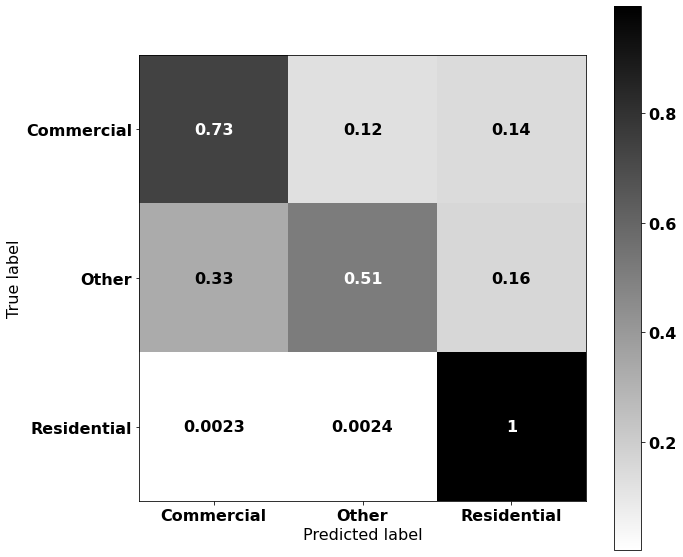

In [28]:
th = 1.0

ixs = np.where( en <= th )
y = yTest.values[ixs]
x = bnnPreds[ixs]
    
cm = confusion_matrix( x, y, normalize='true' )

fig, ax = plt.subplots(figsize=(10, 10))
disp = ConfusionMatrixDisplay( confusion_matrix=cm, display_labels=le.inverse_transform([0,1,2]))#rf.classes_)
disp.plot(ax=ax, cmap='gist_yarg')

In [29]:
print( "Balanced Accuracy:", np.round( balanced_accuracy_score(x,y), 4 ))
print( "Macro F1:", np.round( f1_score(x,y, average='macro'), 4 ))
print( "Macro Precision:", np.round( precision_score(x,y, average='macro'), 4 ))
print( "Macro Recall:", np.round( recall_score(x,y, average='macro'), 4 ))

Balanced Accuracy: 0.7472
Macro F1: 0.7667
Macro Precision: 0.7908
Macro Recall: 0.7472
